In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from copy import deepcopy
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")

C:\Users\yuhan\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%time
df = pd.read_csv("../input/blocks.csv")

from prestep.datetime_extension import timedate_process
df = timedate_process(df)

df['year'] = 2018
df["days"] = pd.to_datetime(df[['year', 'month', 'day']]).dt.dayofyear-91
del df['year']

df_val = df.loc[df.month>=6]
df = df.loc[df.month<6]

from model.produce_matrix import matrixTrans
features,features_add, labels = matrixTrans(df, 0)
features_val,features_add_val, labels_val = matrixTrans(df_val, 0)
print(features.shape)
print(features_add.shape)
print(labels.shape)

new_features = {}
new_features["distribution"] = features
new_features["add_info"] = features_add
new_features_val = {}
new_features_val["distribution"] = features_val
new_features_val["add_info"] = features_add_val

(1158, 60, 20, 7)
(1158, 16)
(1158, 60, 20)
Wall time: 5min 4s


In [9]:
def cnn_model(features, labels, mode):
    # Input Layer
    add_info = features["add_info"]
    features=features["distribution"]
    size = features.shape
    kernel_size = [(3,3),(2,2),(2,2),(1,1)]
    strides = [1,1,1]
    filters = [32, 32, 16,1]

    input_layer = tf.reshape(features, [-1, size[1], size[2], size[3]])
    if not mode == tf.estimator.ModeKeys.PREDICT:
        label_layer = tf.reshape(labels, [-1, size[1]*size[2]])

    # We only add conv layers with 'same' padding in our model
    # since It's a n*n -> n*n prediction (previous distribution -> future prediction)
    # dimensions should be kept same

    # Convolutional Layer and Pooling Layer#1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=filters[0],
      kernel_size=kernel_size[0],
      padding="same",
      activation=tf.nn.elu)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=filters[1],
      kernel_size=kernel_size[1],
      padding="same",
      activation=tf.nn.elu)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
      inputs=conv2,
      filters=filters[2],
      kernel_size=kernel_size[2],
      padding="same",
      activation=tf.nn.elu)
    
    conv4 = tf.layers.conv2d(
      inputs=conv3,
      filters=filters[3],
      kernel_size=kernel_size[3],
      padding="same",
      activation=tf.nn.elu)

    # Dense Layer
    conv4_flat = tf.reshape(conv4, [-1, size[1]*size[2]*filters[3]])
    #add_dense1 = tf.layers.dense(inputs=add_info, units = 4,activation=tf.nn.elu)
    add_dense = tf.layers.dense(inputs=add_info, units = size[1]*size[2]*filters[3])
    
    # Formerly, we use fully-connected layer to make output, 
    # but it costs too much computation resources and may lead to overfitting.
    # As an alternative, we use 1 filter in (1,1) size to make output.
    # Computing time and errors on val_data are reduced.
    #dense = tf.layers.dense(inputs=conv3_flat, units=1024)
    #dropout = tf.layers.dropout(inputs=dense, rate=0.8, training= mode == tf.estimator.ModeKeys.TRAIN)

    # Pred Layer
    pred = tf.keras.activations.relu(
            conv4_flat+add_dense) # We use relu activation here since we don't want a negative prediction

    # Loss
    if not mode == tf.estimator.ModeKeys.PREDICT:
        loss = tf.losses.mean_squared_error(labels=label_layer, predictions=pred)
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "distribution": pred
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=pred)

    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.00005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "mse": tf.metrics.mean_squared_error(
          labels=label_layer, predictions=pred)
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [13]:
distribution_estimator = tf.estimator.Estimator(
    model_fn=cnn_model)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=new_features,
    y=labels,
    num_epochs=None,
    shuffle=True)
distribution_estimator.train(
    input_fn=train_input_fn,
    steps=2500)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\yuhan\\AppData\\Local\\Temp\\tmpx5dnpntc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002833DD18710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 int

In [11]:
val_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=new_features_val,
    y=labels_val,
    num_epochs=None,
    shuffle=True)
distribution_estimator.predict(
    input_fn=val_input_fn)

<generator object Estimator.predict at 0x00000283109969E8>

In [104]:
%%time
def matrixTransByDay(df, level, between=7):
    cols = [c for c in df.columns if c not in ["Level","latBlock","lngBlock","month","day","hour","ClientMacAddr"]]
    tf = deepcopy(df.loc[df['Level'] == level])
    latMax = tf.latBlock.max()+1
    lngMax = tf.lngBlock.max()+1
    orders = sorted(tf.days.unique())

    def generator():
        for d in sorted(tf.days.unique())[between:]:
            yield d

    g = generator()
    #num = 0
    #for h in g:
    #    num+= len(orders)-between
    features = []# np.zeros((num,lngMax,latMax,between))
    features_add = []# np.zeros((num,len(cols)))
    labels = []#np.zeros((num,lngMax,latMax))

    g = generator()
    index = 0
    for d in g:
        temp = tf.loc[tf.days==d]
        hours = [i for i in sorted(temp.hour.unique()) if i<=18 and i>=9]
        n=len(hours)
        label_matrix = np.zeros((n,lngMax,latMax))
        feature_matrix = np.zeros((n,lngMax,latMax,between))
        feature_arr = np.zeros((n,len(cols)))
        for i,hour in enumerate(hours):
            next_ = temp.loc[temp.hour==hour]
            for _,row in next_.iterrows():
                label_matrix[i, row['lngBlock'],row['latBlock']] = row['ClientMacAddr']
            feature_arr[i,:] = next_.iloc[0][cols]
            for b in range(between):
                prev = tf.loc[(tf.days==d-b-1)&(tf.hour==hour)]
                for _, row in prev.iterrows():
                    feature_matrix[i, row['lngBlock'],row['latBlock'],b] = row['ClientMacAddr']
        features.append(feature_matrix)
        features_add.append(feature_arr)
        labels.append(label_matrix)
    return features,features_add, labels

featuresByDay,features_addByDay, labelsByDay = matrixTransByDay(df_val, 0, between=7)

Wall time: 1min 21s


In [105]:
accuracy = {i:[] for i in range(1,11)}
diff = {i:[] for i in range(1,11)}

for i in range(len(featuresByDay)):
    val_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"distribution":featuresByDay[i],
          "add_info":features_addByDay[i]},
        y=labelsByDay[i],
        num_epochs=1,
        shuffle=True)
    pred_matrix = np.zeros(labelsByDay[i].shape)
    for i,pred in enumerate(distribution_estimator.predict(input_fn=val_input_fn)):
        pred_matrix[i,:,:] = pred.reshape((labelsByDay[i].shape[1],labelsByDay[i].shape[2]))
    for t in range(1,11):
        accuracy[t].append(np.mean(np.sum(pred_matrix.argsort(axis=0)[:t]==labelsByDay[i].argmax(axis=0),axis=0)))
        diff[t].append(np.mean(pred_matrix.argsort(axis=0)[:t].max(axis=0)-pred_matrix.argsort(axis=0)[:t].min(axis=0)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpx5dnpntc\model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpx5dnpntc\model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpx5dnpntc\model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpx5dnpntc\model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpx5dnpntc\model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpx5dnpntc\model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling mo

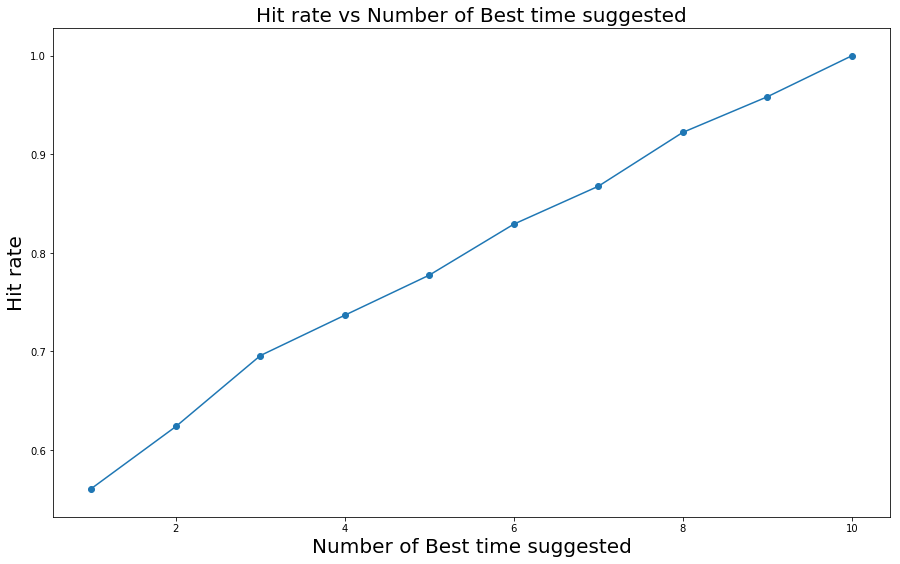

In [98]:
plt.figure(figsize=(15,9))
x = accuracy.keys()
y = [np.mean(accuracy[i]) for i in x]
plt.ylabel("Hit rate",size=20)
plt.xlabel("Number of Best time suggested",size=20)
plt.title("Hit rate vs Number of Best time suggested",size=20)
plt.scatter(x,y)
plt.plot(x,y)
plt.show()

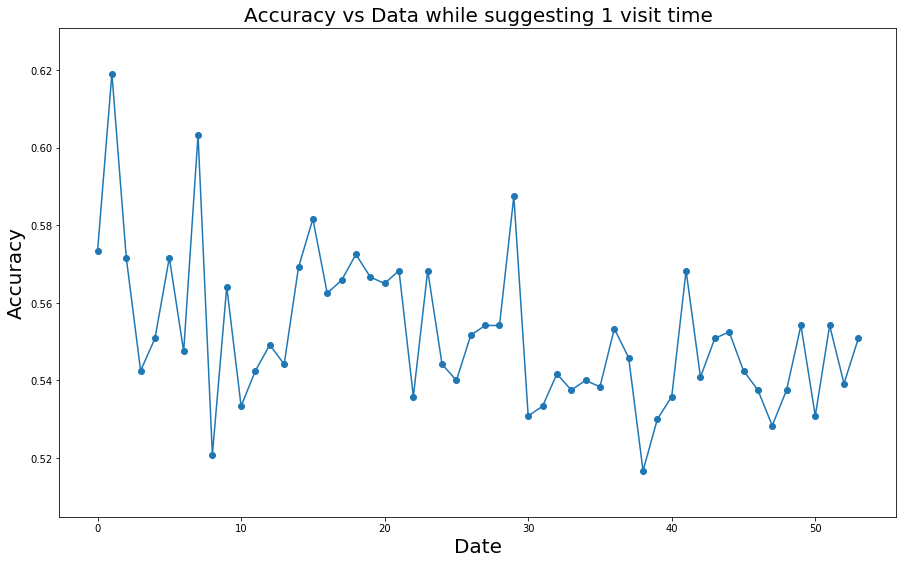

In [120]:
plt.figure(figsize=(15,9))
x = range(len(accuracy[1]))
y = accuracy[1]
plt.ylabel("Accuracy",size=20)
plt.xlabel("Date",size=20)
plt.title("Accuracy vs Data while suggesting 1 visit time",size=20)
plt.scatter(x,y)
plt.plot(x,y)
plt.show()

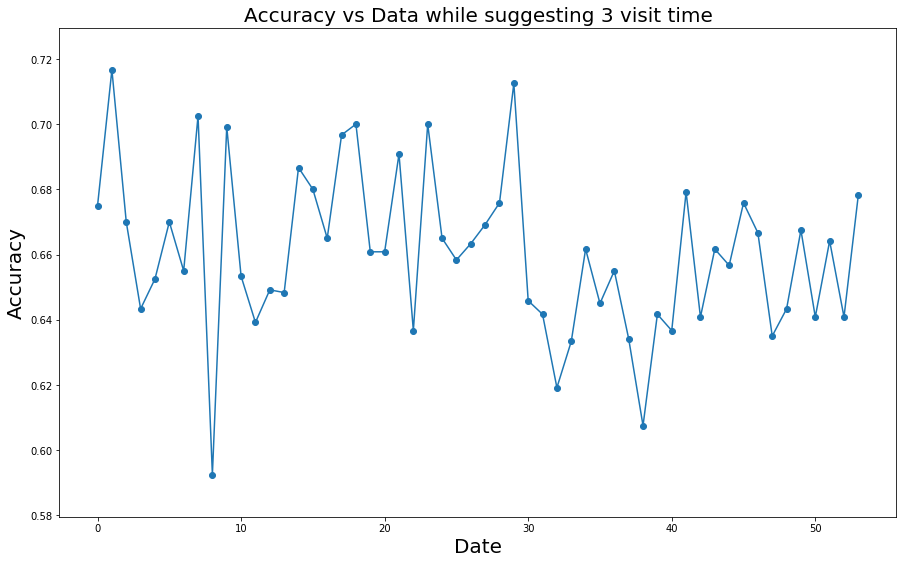

In [119]:
plt.figure(figsize=(15,9))
x = range(len(accuracy[1]))
y = accuracy[3]
plt.ylabel("Accuracy",size=20)
plt.xlabel("Date",size=20)
plt.title("Accuracy vs Data while suggesting 3 visit time",size=20)
plt.scatter(x,y)
plt.plot(x,y)
plt.show()

In [121]:
for i in accuracy:
    print(i,np.mean(accuracy[i]),np.std(accuracy[i]))

1 0.5520833333333334 0.01935545110955363
2 0.5976543209876544 0.024655587515456975
3 0.6603858024691357 0.02490192334106822
4 0.7018672839506173 0.026486629510544313
5 0.7496759259259259 0.02821253144840114
6 0.8020987654320989 0.02781883111726636
7 0.8684876543209877 0.025588281217191068
8 0.9211574074074075 0.02413547191999977
9 0.9600308641975308 0.015476787147383856
10 1.0 0.0


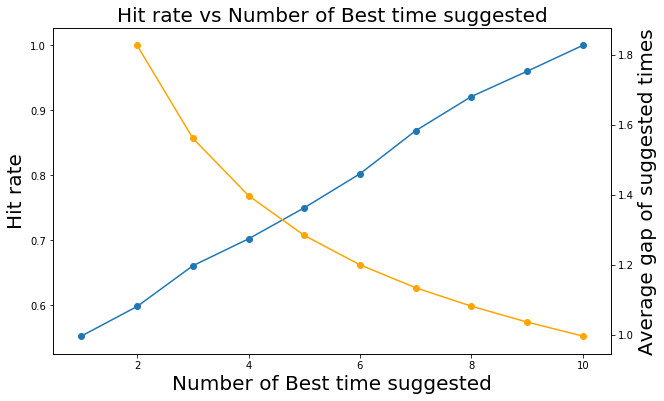

In [117]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
x1 = accuracy.keys()
y1 = [np.mean(accuracy[i]) for i in x1]


ax1.plot(x1,y1)
ax1.scatter(x1,y1)
ax1.set_ylabel('Hit rate',size=20)
ax1.set_xlabel('Number of Best time suggested',size=20)
ax1.set_title("Hit rate vs Number of Best time suggested",size=20)

ax2 = ax1.twinx()
x2 = [i for i in accuracy.keys() if i !=1]
y2 = [np.mean(diff[i])/(i-1) for i in x2]
ax2.plot(x2,y2,'orange')
ax2.scatter(x2,y2,color='orange')
ax2.set_ylabel('Average gap of suggested times',size=20)

#plt.annotate("Best iteration", xy=(3400,13.823),xytext = (2400,14.1),color="r",size=15,
#             arrowprops={'arrowstyle':'-|>',"color":"r"})
plt.show()